# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
sns.set(context='paper')

#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import IPython.display as ipd
def allDone():
  ipd.Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True)

In [14]:
from IPython.display import Audio
Audio('wuv.wav', autoplay=True)

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [15]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu
0,51624,male,34,White,High School,Married,25000-34999,30000.0,1.36,6.0,...,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0
1,51630,female,49,White,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,...,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0
2,51638,male,9,White,NaN,NaN,75000-99999,87500.0,1.84,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,51646,male,8,White,NaN,NaN,55000-64999,60000.0,2.33,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,51647,female,45,White,College Grad,Married,75000-99999,87500.0,5.00,6.0,...,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0


In [16]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
df_test.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51625,male,4,Other,NaN,NaN,20000-24999,22500.0,1.07,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51678,male,60,White,High School,Married,15000-19999,17500.0,1.03,5.0,...,NaN,NaN,No,Yes,20.0,1.0,NaN,No,NaN,NaN
2,51694,male,38,White,Some College,Married,20000-24999,22500.0,1.15,6.0,...,No,NaN,No,Yes,23.0,1.0,1.0,No,Heterosexual,NaN
3,51695,male,8,White,NaN,NaN,65000-74999,70000.0,3.55,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51711,female,59,Other,8th Grade,Widowed,20000-24999,22500.0,1.37,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


In [18]:
def fill_bin_mean(dataframe, category, bin_category, bin_size):  # Only works for numerical categories
    df_meancat = pd.DataFrame(columns=['interval', 'mean'])
    for age_bin, subset in dataframe.groupby(pd.cut(dataframe[bin_category], np.arange(0, dataframe[bin_category].max()+1, bin_size), include_lowest=True)):
        row = [age_bin, subset[category].mean()]
        df_meancat.loc[len(df_meancat)] = row
    for index, row_df in df[df[category].isna()].iterrows():
        for _, row_meancat in df_meancat.iterrows():
            if row_df[bin_category] in row_meancat['interval']:
                dataframe.at[index, category] = row_meancat['mean']
    return dataframe

In [19]:
def fill_bin_num(dataframe, feature, bin_feature, bin_size, stat_measure, min_bin=None, max_bin=None, default_val='No'):
    if min_bin is None:
        min_bin = dataframe[bin_feature].min()
    if max_bin is None:
        max_bin = dataframe[bin_feature].max()
    new_dataframe = dataframe.copy()
    df_meancat = pd.DataFrame(columns=['interval', 'stat_measure'])
    for num_bin, subset in dataframe.groupby(pd.cut(dataframe[bin_feature], np.arange(min_bin, max_bin+bin_size, bin_size), include_lowest=True)):
        if stat_measure is 'mean':
            row = [num_bin, subset[feature].mean()]
        elif stat_measure is 'mode':
            mode_ar = subset[feature].mode().values
            if len(mode_ar) > 0:
                row = [num_bin, mode_ar[0]]
            else:
                row = [num_bin, default_val]
        else:
            raise Exception('Unknown statistical measure: ' + stat_measure)
        df_meancat.loc[len(df_meancat)] = row
    for index, row_df in dataframe[dataframe[feature].isna()].iterrows():
        for _, row_meancat in df_meancat.iterrows():
            if row_df[bin_feature] in row_meancat['interval']:
                new_dataframe.at[index, feature] = row_meancat['stat_measure']
    return new_dataframe


def make_dummy_cols(dataframe, column, prefix, drop_dummy):
    dummy = pd.get_dummies(dataframe[column], prefix=prefix)
    dummy = dummy.drop(columns=prefix+'_'+drop_dummy)
    dataframe = pd.concat([dataframe, dummy], axis=1)
    dataframe = dataframe.drop(columns=column)
    return dataframe


def cleaning(dataframe_raw):
    dataframe = dataframe_raw.copy()

    dataframe = dataframe.set_index('ID')

    dataframe.loc[(dataframe['Age']<=13) & (dataframe['Education'].isna()), 'Education'] = 'Lower School/Kindergarten'
    dataframe.loc[(dataframe['Age']==14) & (dataframe['Education'].isna()), 'Education'] = '8th Grade'
    dataframe.loc[(dataframe['Age']<=17) & (dataframe['Education'].isna()), 'Education'] = '9 - 11th Grade'
    dataframe.loc[(dataframe['Age']<=21) & (dataframe['Education'].isna()), 'Education'] = 'High School'
    dataframe['Education'] = dataframe['Education'].fillna('Some College')

    dataframe.loc[(dataframe['Age']<=20) & (dataframe['MaritalStatus'].isna()), 'MaritalStatus'] = 'NeverMarried'
    dataframe.at[dataframe['MaritalStatus'].isna(), 'MaritalStatus'] = 'Married'  # For now this is hardcoded

    dataframe = dataframe.drop(columns=['HHIncome'])

    dataframe.loc[dataframe['HHIncomeMid'].isna(), 'HHIncomeMid'] = dataframe['HHIncomeMid'].mean()

    dataframe.loc[dataframe['Poverty'].isna(), 'Poverty'] = dataframe['Poverty'].mean()

    dataframe.loc[dataframe['HomeRooms'].isna(), 'HomeRooms'] = dataframe['HomeRooms'].mean()

    dataframe.loc[dataframe['HomeOwn'].isna(), 'HomeOwn'] = dataframe['HomeOwn'].mode().values[0]

    dataframe.loc[(dataframe['Work'].isna()) & (dataframe['Education'].isna()) & (dataframe['Age']<=20), 'Work'] = 'NotWorking'

    dataframe.loc[dataframe['Work'].isna(), 'Work'] = dataframe['Work'].mode().values[0]

    dataframe = fill_bin_num(dataframe, 'Weight', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['HeadCirc'])

    for index, row in dataframe.iterrows():
        if np.isnan(row['Height']) and not np.isnan(row['Length']):
            dataframe.at[index, 'Height'] = row['Length']
    dataframe = fill_bin_num(dataframe, 'Height', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['Length'])

    for index, row in dataframe[dataframe['BMI'].isna()].iterrows():
        dataframe.at[index, 'BMI'] = row['Weight'] / ((row['Height']/100)**2)

    dataframe = dataframe.drop(columns='BMICatUnder20yrs')

    dataframe = dataframe.drop(columns='BMI_WHO')

    dataframe = fill_bin_num(dataframe, 'Pulse', 'Age', 10, 'mean')

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPSysAve'].isna()), 'BPSysAve'] = 105
    dataframe = fill_bin_num(dataframe, 'BPSysAve', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPDiaAve'].isna()), 'BPDiaAve'] = 60
    dataframe = fill_bin_num(dataframe, 'BPDiaAve', 'Age', 5, 'mean', 10)

    dataframe = dataframe.drop(columns='BPSys1')

    dataframe = dataframe.drop(columns='BPDia1')

    dataframe = dataframe.drop(columns='BPSys2')

    dataframe = dataframe.drop(columns='BPDia2')

    dataframe = dataframe.drop(columns='BPSys3')

    dataframe = dataframe.drop(columns='BPDia3')

    dataframe = dataframe.drop(columns=['Testosterone'])

    # Set to 0 for the time being because I cannot find the values
    dataframe.loc[(dataframe['Age']<10) & (dataframe['DirectChol'].isna()), 'DirectChol'] = 0
    dataframe = fill_bin_num(dataframe, 'DirectChol', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['TotChol'].isna()), 'TotChol'] = 0
    dataframe = fill_bin_num(dataframe, 'TotChol', 'Age', 5, 'mean', 10)

    dataframe = dataframe.drop(columns=['UrineVol1'])

    dataframe = dataframe.drop(columns=['UrineFlow1'])

    dataframe = dataframe.drop(columns=['UrineVol2'])

    dataframe = dataframe.drop(columns=['UrineFlow2'])

    dataframe['Diabetes'] = dataframe['Diabetes'].fillna('No')

    dataframe['DiabetesAge'] = dataframe['DiabetesAge'].fillna(0)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['HealthGen'].isna()), 'HealthGen'] = 'Good'
    dataframe = fill_bin_num(dataframe, 'HealthGen', 'Age', 5, 'mode', 10)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<=15) & (dataframe['LittleInterest'].isna()), 'LittleInterest'] = 'None'
    dataframe = fill_bin_num(dataframe, 'LittleInterest', 'Age', 5, 'mode', 15)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    dataframe['nPregnancies'] = dataframe['nPregnancies'].fillna(0)

    dataframe['nBabies'] = dataframe['nBabies'].fillna(0)

    dataframe['Age1stBaby'] = dataframe['Age1stBaby'].fillna(0)

    dataframe.loc[(dataframe['Age']==0) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 14
    dataframe.loc[(dataframe['Age']<=2) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 12
    dataframe.loc[(dataframe['Age']<=5) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 10
    dataframe.loc[(dataframe['Age']<=10) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 9
    dataframe.loc[(dataframe['Age']<=15) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 8
    dataframe['SleepHrsNight'] = dataframe['SleepHrsNight'].fillna(dataframe_raw['SleepHrsNight'].mean())

    dataframe['SleepTrouble'] = dataframe['SleepTrouble'].fillna(0)

    dataframe.loc[(dataframe['Age']<=4) & (dataframe['PhysActive'].isna()), 'PhysActive'] = 'No'
    dataframe = fill_bin_num(dataframe, 'PhysActive', 'Age', 2, 'mode', 16)
    dataframe['PhysActive'] = dataframe['PhysActive'].fillna('Yes') # Big assumption here. All kids between 4 and 16 are physically active

    dataframe = dataframe.drop(columns=['PhysActiveDays'])

    dataframe = dataframe.drop(columns=['TVHrsDay'])

    dataframe = dataframe.drop(columns=['TVHrsDayChild'])

    dataframe = dataframe.drop(columns=['CompHrsDay'])

    dataframe = dataframe.drop(columns=['CompHrsDayChild'])

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Alcohol12PlusYr'].isna()), 'Alcohol12PlusYr'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Alcohol12PlusYr', 'Age', 5, 'mode', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholDay'].isna()), 'AlcoholDay'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholDay', 'Age', 5, 'mode', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholYear'].isna()), 'AlcoholYear'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholYear', 'Age', 5, 'mode', 18)

    dataframe.loc[(dataframe['Age']<20) & (dataframe['SmokeNow'].isna()), 'SmokeNow'] = 'No'
    dataframe = fill_bin_num(dataframe, 'SmokeNow', 'Age', 5, 'mode', 20)

    dataframe['Smoke100'] = dataframe['Smoke100'].fillna('No')

    dataframe['Smoke100n'] = dataframe['Smoke100'].fillna('No')

    dataframe.loc[(dataframe['SmokeNow']=='No') & (dataframe['SmokeAge'].isna()), 'SmokeAge'] = 0
    dataframe = fill_bin_num(dataframe, 'SmokeAge', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Marijuana'].isna()), 'Marijuana'] = 'No'
    dataframe.loc[(dataframe['Marijuana'].isna()) & (dataframe['SmokeNow']=='No'), 'Marijuana'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Marijuana', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['AgeFirstMarij'].isna()), 'AgeFirstMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeFirstMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['RegularMarij'].isna()), 'RegularMarij'] = 'No'
    dataframe = fill_bin_num(dataframe, 'RegularMarij', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['RegularMarij']=='No') & (dataframe['AgeRegMarij'].isna()), 'AgeRegMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeRegMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['HardDrugs'].isna()), 'HardDrugs'] = 'No'
    dataframe = fill_bin_num(dataframe, 'HardDrugs', 'Age', 5, 'mode', 18)

    mode_sex_age = dataframe['SexAge'].mode()[0]
    dataframe.loc[(dataframe['Age']<=mode_sex_age) & (dataframe['SexEver'].isna()), 'SexEver'] = 'No'
    dataframe['SexEver'] = dataframe['SexEver'].fillna('Yes')

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexAge'].isna()), 'SexAge'] = 0
    dataframe.loc[(dataframe['SexAge'].isna() & (dataframe['Age']<mode_sex_age)), 'SexAge'] = dataframe.loc[(dataframe['SexAge'].isna() & (dataframe['Age']<mode_sex_age)), 'Age']
    dataframe['SexAge'] = dataframe['SexAge'].fillna(mode_sex_age)

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartnLife'].isna()), 'SexNumPartnLife'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartnLife', 'Age', 5, 'mean')
    dataframe['SexNumPartnLife'] = dataframe_raw.loc[(dataframe_raw['Age'] >= 60) & (dataframe_raw['Age'] <= 70), 'SexNumPartnLife'].mode()[0] # Missing values for the elderly. Assumed that lifetime sex partners do not increase after 60.

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartYear'].isna()), 'SexNumPartYear'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartYear', 'Age', 10, 'mean')
    dataframe['SexNumPartYear'] = dataframe['SexNumPartYear'].fillna(0)

    dataframe = dataframe.drop(columns=['SameSex'])

    dataframe = dataframe.drop(columns=['SexOrientation']) # Maybe this should not be dropped

    dataframe['PregnantNow'] = dataframe['PregnantNow'].fillna('No')


    # Making dummy variables
    dataframe['male'] = 1*(dataframe['Gender'] ==  'male')
    dataframe = dataframe.drop(columns=['Gender'])

    dataframe['white'] = np.where(dataframe['Race1'] == 'white',1,0)
    dataframe = dataframe.drop(columns=['Race1'])

    dataframe = make_dummy_cols(dataframe, 'Education', 'education', '8th Grade')

    dataframe = make_dummy_cols(dataframe, 'MaritalStatus', 'maritalstatus', 'Separated')

    dataframe = make_dummy_cols(dataframe, 'HomeOwn', 'homeown', 'Other')

    dataframe = make_dummy_cols(dataframe, 'Work', 'work', 'Looking')

    dataframe['Diabetes'] = np.where(dataframe['Diabetes'] == 'Yes',1,0)

    dataframe = make_dummy_cols(dataframe, 'HealthGen', 'healthgen', 'Poor')

    dataframe = make_dummy_cols(dataframe, 'LittleInterest', 'littleinterest', 'None')

    dataframe = make_dummy_cols(dataframe, 'Depressed', 'depressed', 'None')

    dataframe['SleepTrouble'] = np.where(dataframe['SleepTrouble'] == 'Yes',1,0)

    dataframe['PhysActive'] = np.where(dataframe['PhysActive'] == 'Yes',1,0)


    dataframe['Alcohol12PlusYr'] = np.where(dataframe['Alcohol12PlusYr'] == 'Yes',1,0)

    dataframe['SmokeNow'] = np.where(dataframe['SmokeNow'] == 'Yes',1,0)

    dataframe['Smoke100'] = np.where(dataframe['Smoke100'] == 'Yes',1,0)

    dataframe['Smoke100n'] = np.where(dataframe['Smoke100n'] == 'Yes',1,0)

    dataframe['Marijuana'] = np.where(dataframe['Marijuana'] == 'Yes',1,0)

    dataframe['RegularMarij'] = np.where(dataframe['RegularMarij'] == 'Yes',1,0)

    dataframe['HardDrugs'] = np.where(dataframe['HardDrugs'] == 'Yes',1,0)

    dataframe['SexEver'] = np.where(dataframe['SexEver'] == 'Yes',1,0)

    # dataframe['Heterosexual'] = np.where(dataframe['SexOrientation'] == 'Heterosexual',1,0)
    # dataframe = dataframe.drop(columns=['SexOrientation'])

    dataframe['PregnantNow'] = np.where(dataframe['PregnantNow'] == 'Yes',1,0)

    return dataframe


## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

In [20]:
def expected_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [21]:
### fancy models that solve the problem
num = df.select_dtypes(include = 'number')

In [22]:
num = num.set_index('ID')
num.fillna(0, inplace=True)

In [23]:
from sklearn import tree
from sklearn.model_selection import train_test_split


train, test = train_test_split(num, test_size=0.2, stratify=num['flu'])

X_train = train.drop('flu', axis=1)
X_test = test.drop('flu', axis=1)
y_train = train['flu']
y_test = test['flu']

# Random Forests

In [176]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

array([0.68052109, 0.72903879, 0.60539376, 0.61016064, 0.73054068,
       0.62792216, 0.70817248, 0.62965386, 0.74445462, 0.64421252])

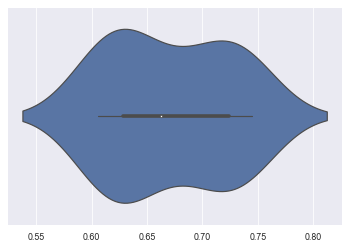

In [177]:
from sklearn.model_selection import cross_val_score

rf_s = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
sns.violinplot(rf_s)
rf_s

In [178]:
def random_forest(it, X_train, y_train, score='roc_auc',cv=5):
    df = pd.DataFrame()
    models = {}
    for i in it:
        rf = RandomForestClassifier(max_depth=4,n_estimators=i, class_weight='balanced')
        rf.fit(X_train, y_train)
        models[i] = rf
        df[i] = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring=score, cv=cv)
    return df,models

In [179]:
rf, models = random_forest(range(22,202,10), X_train, y_train)

,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162,172,182,192
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.681690,0.690732,0.681953,0.686859,0.693253,0.692655,0.690707,0.695901,0.691955,0.699275,0.691812,0.690900,0.686662,0.691008,0.694626,0.696714,0.697832,0.696422
std,0.044182,0.053452,0.050221,0.047670,0.049855,0.054947,0.052868,0.056919,0.049156,0.050865,0.050281,0.041472,0.051290,0.044328,0.057394,0.049345,0.053422,0.054720
min,0.632701,0.600525,0.600557,0.619660,0.628460,0.613393,0.614840,0.610280,0.620641,0.624759,0.614987,0.629089,0.609578,0.626336,0.615003,0.623852,0.626949,0.617896
25%,0.644802,0.682714,0.667794,0.653593,0.659231,0.661470,0.657924,0.671471,0.663848,0.676537,0.673236,0.671177,0.664461,0.667092,0.654165,0.667860,0.659248,0.664771
50%,0.692536,0.721427,0.702471,0.715685,0.708190,0.715742,0.715250,0.713387,0.709400,0.716069,0.707874,0.706099,0.704317,0.707392,0.725218,0.722444,0.715277,0.720185
75%,0.695591,0.723023,0.715807,0.716737,0.714632,0.720953,0.722517,0.727325,0.725038,0.720005,0.716312,0.713138,0.712567,0.716377,0.727994,0.729745,0.730349,0.723652
max,0.742818,0.725970,0.723135,0.728617,0.755752,0.751716,0.743006,0.757043,0.740849,0.759004,0.746650,0.734999,0.742385,0.737842,0.750752,0.739672,0.757337,0.755605


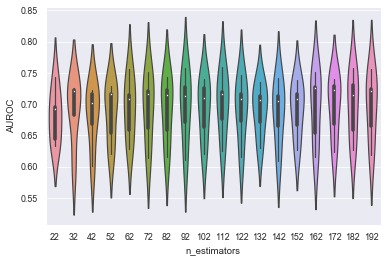

In [180]:
ax = sns.violinplot(data = rf)
ax.set(xlabel='n_estimators', ylabel='AUROC')
rf.describe()

In [181]:
score(models[112], X_test, y_test)

overall accuracy       0.858994
accuracy on class 0    0.886548
accuracy on class 1    0.423077
dtype: float64

In [182]:
data = cleaning(df).select_dtypes(include = 'number')

In [183]:

train, test = train_test_split(data, stratify=data['flu'])

X_train = train.drop('flu', axis=1)
X_test = test.drop('flu', axis=1)
y_train = train['flu']
y_test = test['flu']

In [184]:
rf, models = random_forest(range(2,202,10), X_train, y_train, score='roc_auc', cv=10)

,2,12,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162,172,182,192
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.609024,0.676499,0.682686,0.692215,0.692296,0.698886,0.694459,0.701178,0.693678,0.699116,0.690948,0.697372,0.698085,0.694673,0.694782,0.699659,0.698208,0.697201,0.699123,0.701069
std,0.060064,0.079205,0.049123,0.061599,0.063063,0.066342,0.059946,0.062929,0.053999,0.058560,0.059161,0.058833,0.057305,0.066884,0.062557,0.058881,0.061194,0.057709,0.063267,0.067527
min,0.512048,0.509958,0.581559,0.604088,0.590114,0.592595,0.599092,0.592791,0.599909,0.604251,0.598603,0.595860,0.595076,0.593705,0.601998,0.606504,0.602488,0.594815,0.596448,0.599190
25%,0.566009,0.651996,0.659582,0.635806,0.646964,0.659689,0.653902,0.666286,0.654709,0.681642,0.662161,0.663811,0.666687,0.654340,0.658311,0.671966,0.664482,0.675789,0.653996,0.659778
50%,0.627547,0.684643,0.686926,0.711751,0.707243,0.709466,0.688397,0.709253,0.704960,0.706069,0.704780,0.708660,0.706988,0.708446,0.691398,0.707490,0.703921,0.709959,0.707188,0.705957
75%,0.636803,0.721241,0.724220,0.726560,0.743936,0.750890,0.744547,0.748446,0.731848,0.733898,0.730010,0.746508,0.738044,0.742085,0.742019,0.737306,0.743228,0.730899,0.751028,0.750706
max,0.708925,0.792608,0.736385,0.777850,0.770987,0.786241,0.769361,0.781866,0.757542,0.783858,0.767500,0.756693,0.770014,0.774096,0.781442,0.785686,0.783662,0.763953,0.780593,0.801685


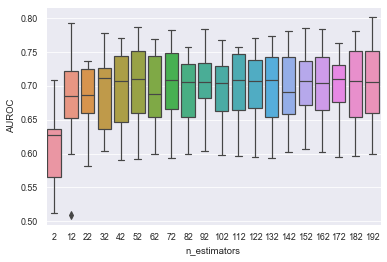

In [185]:
ax = sns.boxplot(data = rf)
ax.set(xlabel='n_estimators', ylabel='AUROC')
rf.describe()

In [186]:
def flu_accuracy(models):
    accuracy = {}
    for k, mod in models.items():
        accuracy[k] = score(mod[1],X_test,y_test)[2]
    plt.scatter(accuracy.keys(), accuracy.values())

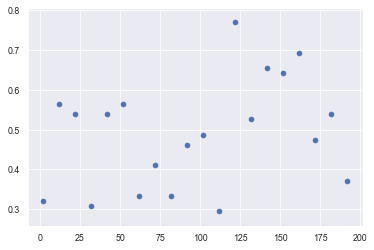

In [187]:
flu_accuracy(models)

In [189]:
score(models[72], X_test, y_test)

overall accuracy       0.846037
accuracy on class 0    0.875203
accuracy on class 1    0.384615
dtype: float64

Now I'm gonna try to improve the class weight

array([0.68179444, 0.77327935, 0.67314222, 0.61665796, 0.74121719,
       0.60030038, 0.71883792, 0.66171563, 0.72983053, 0.77481515])

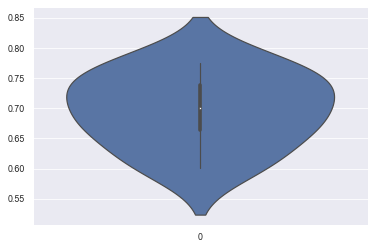

In [655]:
rf = RandomForestClassifier(max_depth=4,n_estimators=62, class_weight={0:0.05, 1:0.95})
rf.fit(X_train, y_train)
ma = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
sns.violinplot(data = ma)
ma

In [656]:
score(rf, X_test, y_test)

overall accuracy       0.781250
accuracy on class 0    0.792545
accuracy on class 1    0.602564
dtype: float64

# Final results and printing

In [657]:
#num_test = df_test.select_dtypes(include='number')
#num_test = num_test.set_index('ID')
#num_test.fillna(0, inplace=True) 

In [42]:
num_test = cleaning(df_test)

In [660]:
num_test

,Age,HHIncomeMid,Poverty,HomeRooms,Weight,Height,BMI,Pulse,BPSysAve,BPDiaAve,...,work_NotWorking,work_Working,healthgen_Excellent,healthgen_Fair,healthgen_Good,healthgen_Vgood,littleinterest_Most,littleinterest_Several,depressed_Most,depressed_Several
ID,,,,,,,,,,,,,,,,,,,,,
51625,4,22500.0,1.07,9.0,17.0,105.4,15.30,83.565217,105.0,60.0,...,0,1,0,0,1,0,0,0,0,0
51678,60,17500.0,1.03,5.0,74.6,169.9,25.84,84.000000,152.0,100.0,...,0,1,0,0,0,1,0,0,0,0
51694,38,22500.0,1.15,6.0,117.3,180.9,35.84,60.000000,147.0,81.0,...,0,1,0,0,0,0,0,1,0,0
51695,8,70000.0,3.55,5.0,40.1,128.4,24.32,76.000000,93.0,54.0,...,0,1,0,0,1,0,0,0,0,0
51711,59,22500.0,1.37,4.0,54.3,145.1,25.79,84.000000,150.0,0.0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71839,57,50000.0,2.04,13.0,120.2,168.4,42.40,84.000000,116.0,71.0,...,0,1,0,1,0,0,0,0,0,0
71847,37,100000.0,5.00,8.0,79.3,174.5,26.00,78.000000,116.0,83.0,...,0,1,0,0,1,0,0,0,0,1
71855,62,12500.0,0.98,4.0,99.0,166.1,35.90,118.000000,143.0,75.0,...,1,0,0,0,1,0,1,0,0,1


In [661]:
a = np.array(rf.predict(num_test))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_c_rf_b.csv', index=False)

In [ ]:
result.to_csv('result2.csv', index=False)

# Random Forests with Grid Search

In [294]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
w0 = 0.0599

param_grid = {
    'n_estimators' : [20,70,110, 150, 200],
    'max_features' : ['auto', 'sqrt'], 
    'max_depth':[3, 5, 7, 10, None],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 3, 5, 7],
    'min_samples_leaf' : [2, 3, 5, 7],
    'class_weight': [{0:0.1, 1:0.9},{0:0.06, 1:0.94}, {0:0.05, 1:0.95}, 'balanced', {0:w0,1:1-w0}]
}

In [231]:
print(param_grid)

{'n_estimators': [20, 70, 110, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 5, 7, 10, None], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 5, 7], 'min_samples_leaf': [2, 3, 5, 7], 'class_weight': [{0: 0.1, 1: 0.9}, {0: 0.06, 1: 0.94}, {0: 0.05, 1: 0.95}, 'balanced', {0: 0.0599, 1: 0.9401}]}


In [295]:
rfs = RandomForestClassifier()
rfs_random = RandomizedSearchCV(rfs, param_grid, scoring='balanced_accuracy', cv=5, return_train_score=True, random_state=42, n_jobs=-1, n_iter=1500)

In [296]:
rfs.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

rfs_random.fit(X_train, y_train)

In [298]:
params = rfs_random.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, rfs_random.best_score_))

The best parameters are {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'class_weight': {0: 0.05, 1: 0.95}} giving an average ROC AUC score of 0.6884


In [299]:
rfs_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 3,
 'criterion': 'gini',
 'class_weight': {0: 0.05, 1: 0.95}}

In [300]:
rf = RandomForestClassifier(class_weight= {0:0.05,1:0.95}, criterion='gini', max_depth = 3, max_features = 'auto', min_samples_leaf = 5, min_samples_split=3, n_estimators=70)

rf.fit(data.drop('flu', axis=1), data['flu'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.05, 1: 0.95}, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=70, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [239]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [303]:
a = np.array(rfs_random.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_c_rf_gs_ba_n.csv', index=False)

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca_ready = pd.DataFrame(StandardScaler().fit_transform(num.drop('flu', axis=1)))
pca.fit_transform(pca_ready)
pca_ready

In [ ]:
print(sum(pca.explained_variance_ratio_))

# Support Vector Machine

In [196]:
from sklearn.svm import SVC

clf = SVC(class_weight='balanced', C=100000)
clf.fit(X_train, y_train)

SVC(C=100000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [769]:
score(clf, X_test, y_test)

overall accuracy       0.723323
accuracy on class 0    0.738250
accuracy on class 1    0.487179
dtype: float64

0.6850740804381082

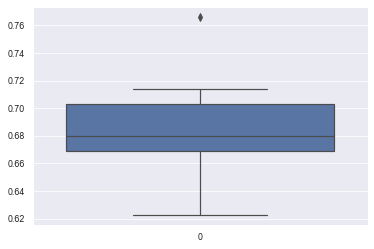

In [766]:
ma = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10)
sns.boxplot(data = ma)
ma.mean()

In [767]:
a = np.array(clf.predict(num_test))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_svm_b.csv', index=False)

# SVM grid search

In [523]:

param_grid = {
    'C':[1, 10, 100],
    'kernel':['linear', 'poly', 'rbf'],
    'degree':[2,3,4],
    'gamma':['scale', 'auto'],
    'shrinking':[True, False],
    'class_weight': [{0:0.1, 1:0.9},{0:0.06, 1:0.94}, {0:0.05, 1:0.95}, 'balanced']
}

In [524]:
from sklearn.model_selection import RandomizedSearchCV
sv = SVC()
sv_r = RandomizedSearchCV(sv, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True, verbose=2, random_state=42, n_jobs=-1, n_iter=150)

In [528]:
sv_r.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 16.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=150, n_jobs=-1,
                   param_distributions={'C': [1, 10, 100],
                                        'class_weight': [{0: 0.1, 1: 0.9},
                                                         {0: 0.06, 1: 0.94},
                                                         {0: 0.05, 1: 0.95},
                                                         'balanced'],
                                        'degree': [2, 3, 4],
                                        'gamma

In [529]:
params = sv_r.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, sv_r.best_score_))

The best parameters are {'shrinking': False, 'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'class_weight': {0: 0.06, 1: 0.94}, 'C': 1} giving an average ROC AUC score of 0.6829


In [530]:
a = np.array(sv_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_svm_gs_4.csv', index=False)

# XGBoost

In [355]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', learning_rate = 0.1, max_depth = 5, alpha = 100, n_estimators = 50, eval_metric='aucpr', scale_pos_weight=25)
xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=100, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
              silent=None, subsample=1, verbosity=1)

In [356]:
score(xg_reg, X_test, y_test)

overall accuracy       0.747713
accuracy on class 0    0.764992
accuracy on class 1    0.474359
dtype: float64

0.7062287694937408

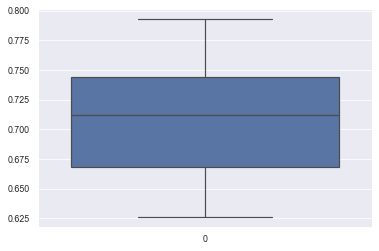

In [350]:
ma = cross_val_score(xg_reg, X_train, y_train, scoring='roc_auc', cv=10)
sns.boxplot(data = ma)
ma.mean()

In [159]:
a = np.array(xg_reg.predict(num_test))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_xg.csv', index=False)

# XGBoost with Grid Search

In [469]:
xg_c = xgb.XGBClassifier(max_depth=3)
param_grid = {
    'objective':['reg:squarederror', 'reg:logistic', 'binary:logistic'],
    'scale_pos_weight':[20,21,22],
    'colsample_bytree':[0.3],
    'eval_metric':['aucpr', 'auc', 'mae', 'map'],
    'alpha':[5, 10, 20],
    'n_estimators': [5, 10, 25, 40, 50, 100, 125],
    'learning_rate': [0.05, 0.1, 0.15]
}
xg_s = GridSearchCV(xg_c, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True)

In [470]:
xg_s.fit(ndata.drop('flu', axis=1), ndata['flu'])

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
             param_grid={'alpha': [5, 10, 20], 'colsample_bytree': [0.3],
                         'eval_metric': ['aucpr', 'auc', 'mae', 'map'],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'n_estimators': [5, 10, 25, 40, 50, 100, 125],
                         'objective': 

In [461]:
params = xg_s.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, xg_s.best_score_))
xg = xg_s.best_estimator_

The best parameters are {'scale_pos_weight': 20, 'objective': 'binary:logistic', 'n_estimators': 25, 'learning_rate': 0.05, 'eval_metric': 'mae', 'colsample_bytree': 0.5, 'alpha': 5} giving an average ROC AUC score of 0.6675


In [362]:
#score(xg_s.best_estimator_, X_test, y_test)

overall accuracy       0.719512
accuracy on class 0    0.728525
accuracy on class 1    0.576923
dtype: float64

In [403]:
#data_dmatrix = xgb.DMatrix(data=ndata.drop('flu', axis=1),label=ndata['flu'])

In [415]:
#xg= xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3,alpha=10, max_depth=3, n_estimators=100, scale_pos_weight=22, learning_rate=0.1, eval_metric='aucpr')
#xg.fit(ndata.drop('flu', axis=1).values, ndata['flu'])

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=22, seed=None,
              silent=None, subsample=1, verbosity=1)

In [424]:
#xg= xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3,alpha=10, max_depth=3, n_estimators=50, scale_pos_weight=20, learning_rate=0.1, eval_metric='aucpr')
#xg.fit(ndata.drop('flu', axis=1).values, ndata['flu'])

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [432]:
#xg= xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3,alpha=10, max_depth=3, n_estimators=10, scale_pos_weight=22, learning_rate=0.2, eval_metric='aucpr')
#xg.fit(ndata.drop('flu', axis=1).values, ndata['flu'])

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=22, seed=None,
              silent=None, subsample=1, verbosity=1)

In [467]:
#xg= xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3,alpha=20, max_depth=3, n_estimators=10, scale_pos_weight=20, learning_rate=0.1, eval_metric='mae')
#xg.fit(ndata.drop('flu', axis=1).values, ndata['flu'])

XGBClassifier(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='mae',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [475]:
xg= xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3,alpha=5, max_depth=3, n_estimators=50, scale_pos_weight=20, learning_rate=0.05, eval_metric='aucpr')
xg.fit(ndata.drop('flu', axis=1).values, ndata['flu'])

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [474]:
params = xg_s.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, xg_s.best_score_))
xg = xg_s.best_estimator_

The best parameters are {'alpha': 5, 'colsample_bytree': 0.3, 'eval_metric': 'aucpr', 'learning_rate': 0.05, 'n_estimators': 50, 'objective': 'reg:logistic', 'scale_pos_weight': 21} giving an average ROC AUC score of 0.6654


In [476]:
a = np.array(xg.predict(ntest.values))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_xg_7.csv', index=False)

# Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight={0:0.06,1:0.94}, C=10)
clf.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 0.06, 1: 0.94}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
score(clf, X_test, y_test)

overall accuracy       0.705030
accuracy on class 0    0.717180
accuracy on class 1    0.512821
dtype: float64

0.7152687670971101

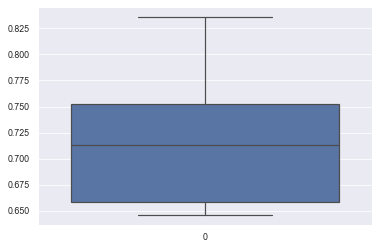

In [31]:
ma = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10)
sns.boxplot(data = ma)
ma.mean()

In [754]:
a = np.array(clf.predict(num_test))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_lr.csv', index=False)

# LR with Grid Search

In [499]:
cw = []
for i in np.linspace(start = 0.001, stop = 0.4, num = 40):
    cw.append({0:i, 1:1-i})
cw.append('balanced')

In [500]:
w0 = 0.0599
param_grid = {
    'C':[x for x in np.linspace(start = 0.01, stop = 100, num = 20)],
    'penalty':['l1', 'l2', 'elasticnet'],
    'max_iter':[10, 100, 1000, 10000],
    'class_weight': cw
}

In [505]:
lr = LogisticRegression()
lr_r = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, return_train_score=True, verbose=0)

In [509]:
lr_r.fit(ndata.drop('flu', axis=1), ndata['flu'])

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 5.272631578947368, 1...
                                          {0: 0.25676923076923075,
                                           1: 0.7432307692307693},
                                          {0: 0.267, 1: 0.733},
                                          {0: 0.2772307692307692,
                           

In [511]:
params = lr_r.best_params_

print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, lr_r.best_score_))

The best parameters are {'C': 5.272631578947368, 'class_weight': {0: 0.36930769230769234, 1: 0.6306923076923077}, 'max_iter': 100, 'penalty': 'l2'} giving an average ROC AUC score of 0.7528


In [487]:
lr_f = LogisticRegression(C = 0.1, class_weight='balanced', max_iter=100, penalty='l2')
lr_f.fit(ndata.drop('flu', axis=1), ndata['flu'])

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [510]:
a = np.array(lr_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_lr_gs_n_ba_7.csv', index=False)

In [ ]:
def scorel(model, X_test, y_test):
    return 0.6*cross_val_score(model,X_train,y_train,scoring='roc_auc', cv=5)+0.4*score(model,X_test, y_test)[1]

In [49]:
scorel(lr_r.best_estimator_, X_test, y_test)

0.3076923076923077

0.7643468164930429

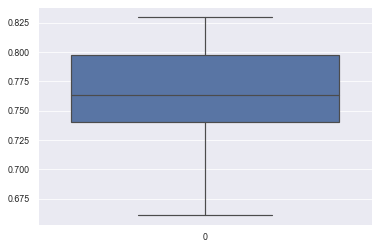

In [331]:
ma = cross_val_score(lr_r.best_estimator_, X_train, y_train, scoring='roc_auc', cv=10)
sns.boxplot(data = ma)
ma.mean()

# Decision Tree

In [309]:
clf = tree.DecisionTreeClassifier()

In [311]:
param_grid = {
    'max_features' : ['auto', 'sqrt'], 
    'max_depth':[3, 5, 7, 10, None],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 3, 5, 7],
    'min_samples_leaf' : [2, 3, 5, 7],
    'class_weight': [{0:0.1, 1:0.9},{0:0.06, 1:0.94}, {0:0.05, 1:0.95}, 'balanced', {0:w0,1:1-w0}]
}

In [317]:
clf_r = RandomizedSearchCV(clf, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True, verbose=0, n_iter=2000)

In [318]:
clf_r.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [319]:
params = clf_r.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, clf_r.best_score_))

The best parameters are {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini', 'class_weight': {0: 0.0599, 1: 0.9401}} giving an average ROC AUC score of 0.6581


In [839]:
score(models[3], X_test, y_test)

overall accuracy       0.694360
accuracy on class 0    0.700162
accuracy on class 1    0.602564
dtype: float64

In [320]:
a = np.array(clf_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_dt_n.csv', index=False)

# With normalization

In [366]:
from sklearn import preprocessing
norm = preprocessing.MinMaxScaler()
data_n = norm.fit_transform(data.drop('flu', axis=1))

In [367]:
ndata = pd.DataFrame(data_n, index = data.index)
ndata['flu'] = data['flu']

In [368]:
ntest = pd.DataFrame(norm.fit_transform(num_test), index=num_test.index)

In [369]:

train, test = train_test_split(ndata, stratify=ndata['flu'])

X_train = train.drop('flu', axis=1)
X_test = test.drop('flu', axis=1)
y_train = train['flu']
y_test = test['flu']

In [293]:
rfs_n = RandomForestClassifier()
rfs_n_random = RandomizedSearchCV(rfs_n, param_grid, scoring='balanced_accuracy', cv=5, return_train_score=True, random_state=42, n_jobs=-1, n_iter=1500)
rfs_n_random.fit(X_train, y_train)

ValueError: Invalid parameter penalty for estimator RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [262]:
params = rfs_n_random.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, rfs_n_random.best_score_))

The best parameters are {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'class_weight': {0: 0.1, 1: 0.9}} giving an average ROC AUC score of 0.3330


In [284]:
rf_n = RandomForestClassifier(n_estimators=70, min_samples_split=2, min_samples_leaf=7, max_features='auto', max_depth=3, criterion='gini', class_weight={0:0.1,1:0.9})
rf_n.fit(train.drop('flu', axis=1), train['flu'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.1, 1: 0.9}, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=70, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [286]:
a = np.array(rf_n.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_rf_f1.csv', index=False)

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [ ]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [ ]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [132]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [ ]:
#same job as before, but faster?

score1 = lambda model, x_val, y_val: model.score(x_val[y_val==1], y_val[y_val==1])

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set